In [2]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

In [17]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

## Switching AR

In [505]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet(ones(nmixtures, nmixtures))

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy(), constraint=EM())
    bs = randomvar(nmixtures, prod_strategy = FoldRightProdStrategy())
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    meta = GammaMixtureNodeMetadata(EM())

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs) where { meta = meta }
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = div(i - 1, k) + 1
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
#     scheduler = schedule_updates(ms, ws, as, bs, z, θ, γ, A)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [701]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(bs), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (a, b, m, w)) in enumerate(zip(as, bs, ms, ws))
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [702]:
ReactiveMP.release!(::Nothing) = nothing

## Generate AR

In [745]:
using Random
Random.seed!(20)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions
ARorder = 2

γs = [0.1, 0.1]
# γs = [0.01, 0.1, 10.0, 1.0]
θs = [[0.9, 0.1], [0.1, 0.2]]
# θs = [0.9, 0.3, -0.3, 0.1]

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

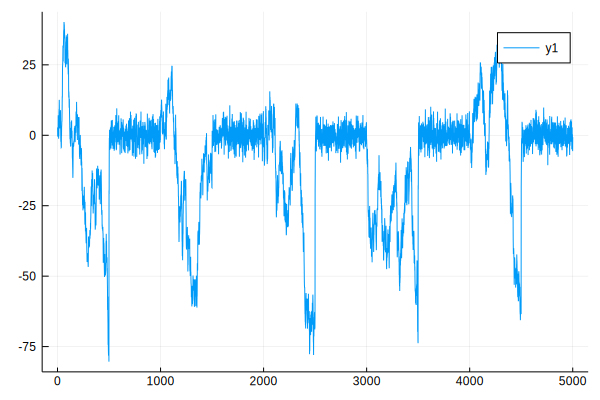

In [746]:
using Plots
plot(outputs)

In [747]:
inputs_

4998-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [-0.7583113688909273, 1.0]
 [-1.9877437947404535, -0.7583113688909273]
 [-1.7789278334147058, -1.9877437947404535]
 [-2.746861278065112, -1.7789278334147058]
 [2.972022499669031, -2.746861278065112]
 [-1.22036241498299, 2.972022499669031]
 [-2.282985836120121, -1.22036241498299]
 [-1.6829545103162593, -2.282985836120121]
 [-10.097666786103634, -1.6829545103162593]
 [-6.083451070913831, -10.097666786103634]
 [-3.062082736151159, -6.083451070913831]
 [-2.7727853971655705, -3.062082736151159]
 ⋮
 [-5.641576927623289, 14.313849420850246]
 [-1.1536943940968858, -5.641576927623289]
 [8.150462240526426, -1.1536943940968858]
 [4.483403706331503, 8.150462240526426]
 [5.785301813475465, 4.483403706331503]
 [13.613210482487272, 5.785301813475465]
 [-0.9516798796891575, 13.613210482487272]
 [4.277687427284157, -0.9516798796891575]
 [-4.061850788133865, 4.277687427284157]
 [-0.0651139635386927, -4.061850788133865]
 [13.108994728879432, -0.065113963

In [748]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:end-ARorder]

4998-element Vector{Float64}:
  2.764554613607447
 -0.46291723233252924
  0.7389524310761977
  2.1561292390774165
  1.6776199640232698
  2.2423658330551954
  7.1003926780594835
  1.3619234636333513
  6.773910795963899
  1.0028356109910872
 -1.2123408906434299
  0.17478981293298335
 -0.27551014195864865
  ⋮
  1.2385170421899954
  4.924629746078045
 -1.865954459468209
  0.7715617728531405
 -4.992712943744468
 -3.1729289281338797
  2.7987436631557223
  2.6250630055934856
 -4.253972180521719
 -2.0383480644940533
  0.3692165248136887
 -4.69965807089451

In [ ]:
csep = 10.0

priors_as = map(γ -> infgamma(Float64, γ*csep), γs)
priors_bs = map(_ -> infgamma(Float64, csep), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ, diageye(ARorder)), θs)
priors_ws = map(_ -> (ARorder, 1e4*diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 500, 1000, priors_as, priors_bs, priors_ms, priors_ws);

Progress:  22%|█████████▏                               |  ETA: 0:02:57

In [750]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.998007   0.568882
 0.0019933  0.431118

In [751]:
minimum(mean.(mγs[end]))

0.0035322937711784936

In [752]:
mean.(mθs[end])

500-element Vector{Vector{Float64}}:
 [0.40936099689926664, 0.5173500537613336]
 [0.7175176624246014, 0.2596480635677203]
 [0.5927836352341131, 0.36530805653237763]
 [0.7534073586074612, 0.22689980661055387]
 [0.9211197177709636, 0.11271609973824326]
 [0.8408434843874062, 0.18179897516978372]
 [0.7251712009665425, 0.266006006669528]
 [0.6372553194661705, 0.324533991643996]
 [0.6733713114165596, 0.30783512992958606]
 [0.6471612967133531, 0.33768114313135555]
 [0.5935542756068628, 0.34961261671563904]
 [0.621906643311295, 0.32593222186873305]
 [0.6331610383947464, 0.329473679267668]
 ⋮
 [0.5739734928409348, 0.37821531237513284]
 [0.35725720466579247, 0.5589284201873888]
 [0.5749638652735243, 0.37786874373675516]
 [0.5905265804625444, 0.3648798410433365]
 [0.580513376298601, 0.37278268868033493]
 [0.5059985754258101, 0.43564465430409527]
 [0.494805493324872, 0.4443062975786276]
 [0.5756326189241641, 0.37777400353292734]
 [0.6151266674859777, 0.34632423981923566]
 [0.480438195357916, 0.454

In [753]:
using Plots

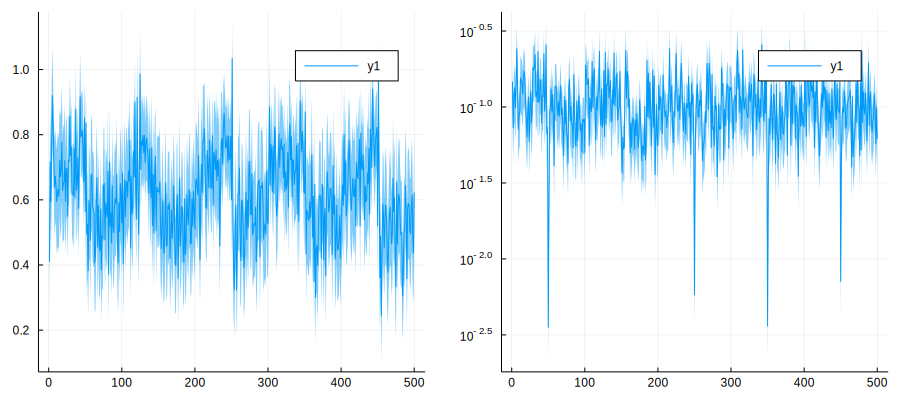

In [754]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index))
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10)

plot(p1, p2, size = (900, 400))

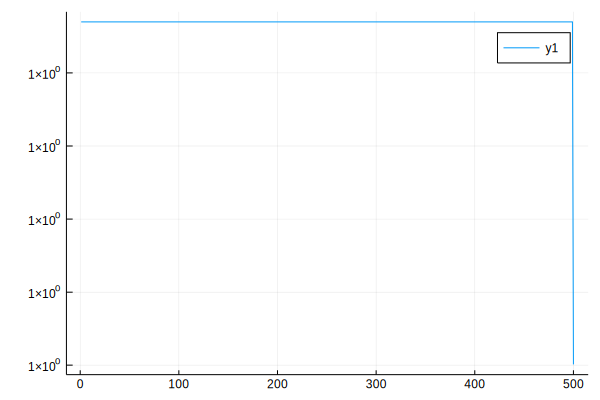

In [755]:
plot(mean.(mzs[end]))

In [756]:
mean.(mzs[end])

500-element Vector{Float64}:
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 ⋮
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000014697
 1.0000000000010012

mfe[end - 4:end] = [13697.96193109316, 13697.425865949437, 13696.91407965661, 13696.425320909822, 13695.958401337155]


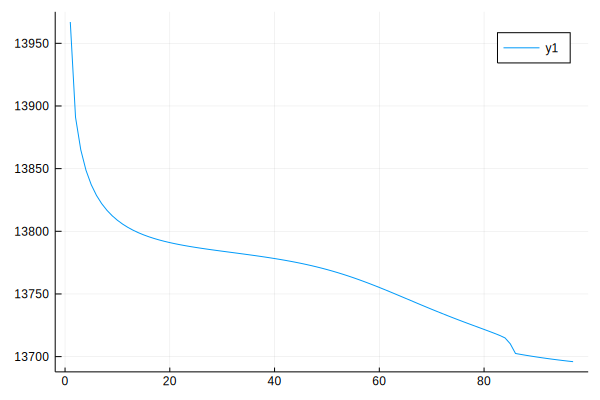

In [757]:
@show mfe[end-4:end]
plot(mfe[4:end])